In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epsilon_greedy import epsilon_greedy_algorithm_random, epsilon_greedy_algorithm_min
import random

In this notebook, we implement the policy evaluator for finite data stream (https://arxiv.org/pdf/1003.5956.pdf)

The context of policy_evaluator depends for each algorithm, thus we can't implement a function that will be the same for every algorithm.

We have slightly modified the policy_evaluator. We consideer payoffs as a list containing all the payoffs value instead of a single number to be able to plot the cumulative average of our payoffs.
We then don't need to add the parameter T as it will be the len of payoffs.

In [17]:
data = pd.read_csv('../Data/dataset_1000_minimum_reviews.csv', index_col='Unnamed: 0')
df = data[['time', 'movie_id', 'user_id', 'binary_rating']]
df_50_popular = pd.read_csv('../Data/dataset_50_most_populars.csv', index_col='Unnamed: 0')
df_100_popular = pd.read_csv('../Data/dataset_100_most_popular.csv', index_col='Unnamed: 0')
df.head()

,time,movie_id,user_id,binary_rating
0,0,1197,3669,0
1,1,780,3621,0
2,2,1234,4917,0
3,3,1544,1147,0
4,4,3175,262,1


We have implementend a policy evaluator that takes into account the fact that several arms can maximize the mean, thus we need to choose on arm. Two rules are possible and popular : choosing an arm randomly or choosing the arm with the lowest id.

In [4]:
def policy_evaluator_epsilon_random(dataframe, epsilon_value = 0.15):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the payoffs in a list
    payoffs = []
    for t in range(len(dataframe)):
        # We check our t-th row
        t_event = dataframe[t : t + 1]
        # If the movie recommended matches the movie of our dataframe, we update our history and our payoffs
        if epsilon_greedy_algorithm_random(history, arms, epsilon=epsilon_value, n_recommendations=1) == t_event['movie_id'].iloc[0] :
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])
    return payoffs

In [5]:
def policy_evaluator_epsilon_min(dataframe, epsilon_value = 0.15):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the payoffs in a list
    payoffs = []
    for t in range(len(dataframe)):
        # We check our t-th row
        t_event = dataframe[t : t + 1]
        # If the movie recommended matches the movie of our dataframe, we update our history and our payoffs
        if epsilon_greedy_algorithm_min(history, arms, epsilon=epsilon_value, n_recommendations=1) == t_event['movie_id'].iloc[0] :
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])
    return payoffs

On our dataframe with at least 1000 reviews per movie

In [7]:
payoffs1 = policy_evaluator_epsilon_random(df, epsilon_value = 0.15)

In [8]:
payoffs2 = policy_evaluator_epsilon_min(df, epsilon_value = 0.15)

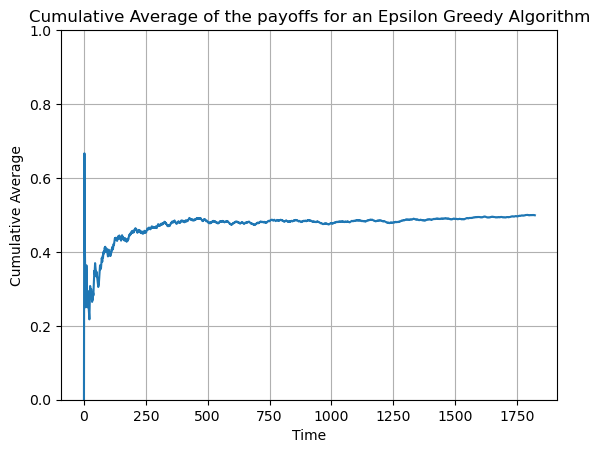

In [13]:
cumulative_average = np.cumsum(payoffs1) / np.arange(1, len(payoffs1)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

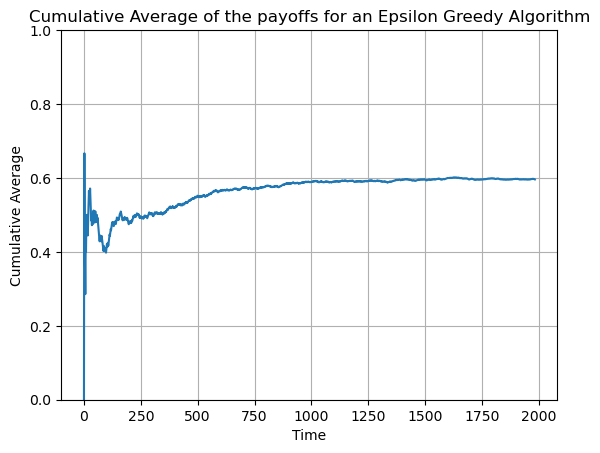

In [16]:
cumulative_average = np.cumsum(payoffs2) / np.arange(1, len(payoffs2)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

No big differences between both algorithm, we thus decide to keep the argmin.

In [29]:
epsilon_values = [0.001, 0.01, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9, 0.99, 0.999]

In [32]:
for epsilon_value in epsilon_values:
    payoffs = policy_evaluator_epsilon_min(df, epsilon_value = epsilon_value)
    pd.DataFrame(payoffs).to_csv(f'epsilon_greedy_{epsilon_value}.csv')

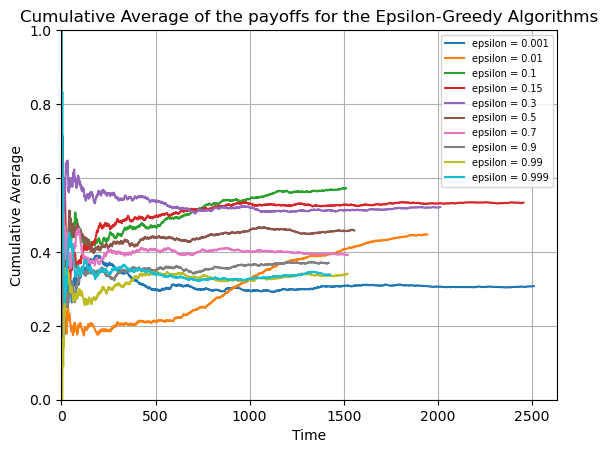

In [63]:
for epsilon_value in epsilon_values:
    filename = f'epsilon_greedy_{epsilon_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'epsilon = {epsilon_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Epsilon-Greedy Algorithms")
plt.xlim(0,)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

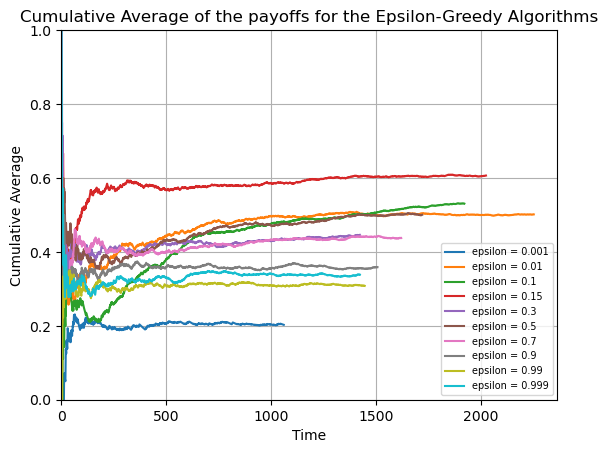

In [65]:
for epsilon_value in epsilon_values:
    payoffs = policy_evaluator_epsilon_min(df, epsilon_value = epsilon_value)
    pd.DataFrame(payoffs).to_csv(f'epsilon_greedy_{epsilon_value}.csv')

for epsilon_value in epsilon_values:
    filename = f'epsilon_greedy_{epsilon_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'epsilon = {epsilon_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Epsilon-Greedy Algorithms")
plt.xlim(0,)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

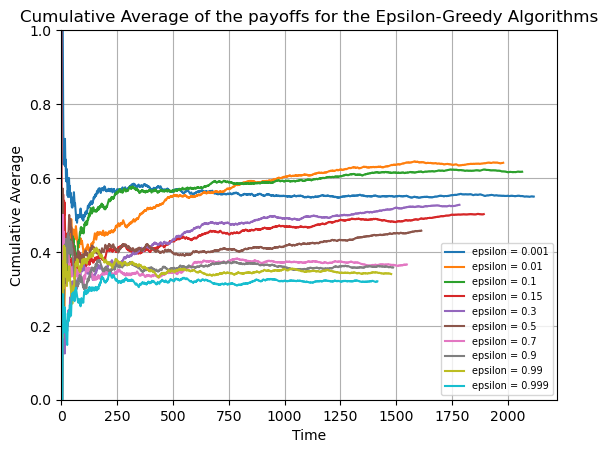

In [66]:
for epsilon_value in epsilon_values:
    payoffs = policy_evaluator_epsilon_min(df, epsilon_value = epsilon_value)
    pd.DataFrame(payoffs).to_csv(f'epsilon_greedy_{epsilon_value}.csv')

for epsilon_value in epsilon_values:
    filename = f'epsilon_greedy_{epsilon_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'epsilon = {epsilon_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Epsilon-Greedy Algorithms")
plt.xlim(0,)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

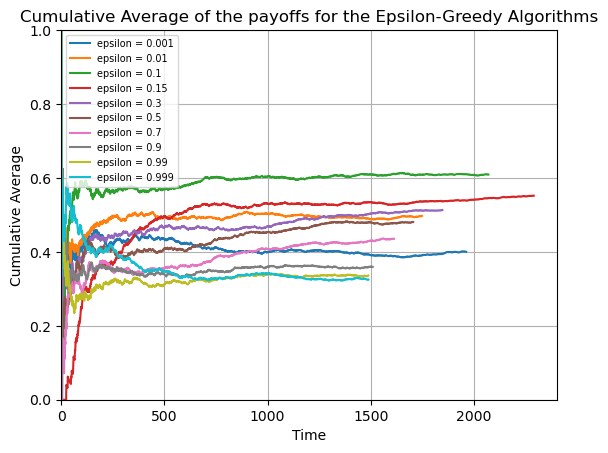

In [67]:
for epsilon_value in epsilon_values:
    payoffs = policy_evaluator_epsilon_min(df, epsilon_value = epsilon_value)
    pd.DataFrame(payoffs).to_csv(f'epsilon_greedy_{epsilon_value}.csv')

for epsilon_value in epsilon_values:
    filename = f'epsilon_greedy_{epsilon_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'epsilon = {epsilon_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Epsilon-Greedy Algorithms")
plt.xlim(0,)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

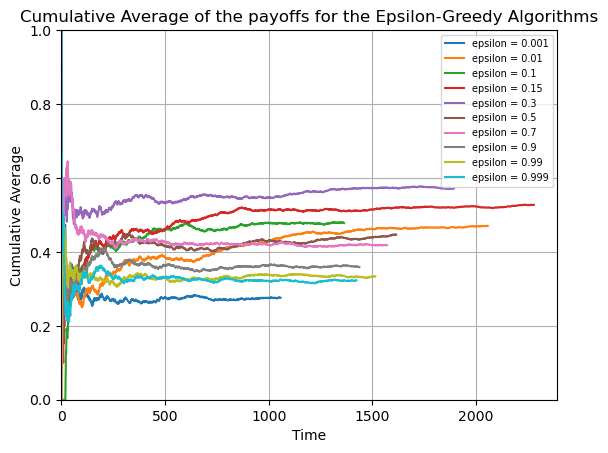

In [68]:
for epsilon_value in epsilon_values:
    payoffs = policy_evaluator_epsilon_min(df, epsilon_value = epsilon_value)
    pd.DataFrame(payoffs).to_csv(f'epsilon_greedy_{epsilon_value}.csv')

for epsilon_value in epsilon_values:
    filename = f'epsilon_greedy_{epsilon_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'epsilon = {epsilon_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Epsilon-Greedy Algorithms")
plt.xlim(0,)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

We also wanted to implement some alternatives policies. Below are some examples.

Instead of checking recommandations line by line, we check them by blocks. This means that for a block of size S, at each iteration t we ask our algorithm to recommend us S movies, and check if there are some S of these movies in our dataframe by looking the t*S+1, ... t*S+S rows. This isn't exactly the same as the Policy Evaluation in the research paper as it is possible that a recommendation made by the bandit algorithm can match with a row from the entire block, and not only the associated lign of the block.

In [112]:
def block_policy_evaluator_epsilon(dataframe, epsilon_value = 0.15, block_size=50):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the payoffs in a list
    payoffs = []
    for t in range(len(dataframe) // block_size):
        # As explained, we consideer a block and not a single observation
        time = t*block_size
        t_event = dataframe[time : time + block_size]
        # If recommendations matches the movies in our data, We update our history and payoffs
        recommendations = epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=block_size)
        # We focus on the matches
        good_recommendations = t_event[t_event['movie_id'].isin(recommendations)]
        # We update our history
        history = pd.concat([history, good_recommendations])
        # We update the payoffs
        payoffs.extend(good_recommendations['binary_rating'].to_list())
    return payoffs

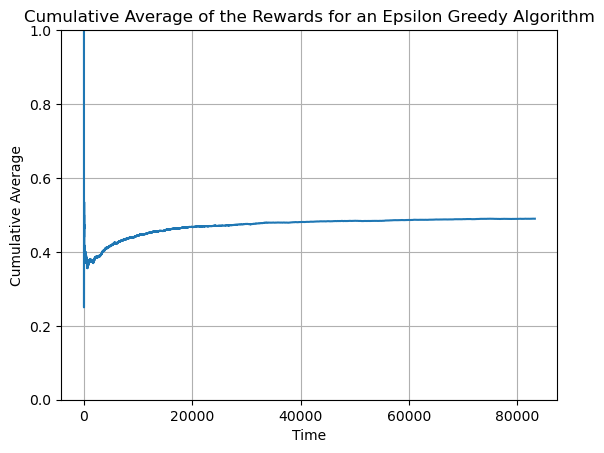

In [132]:
payoffs_2 = block_policy_evaluator_epsilon(df, epsilon_value = 0.15)
cumulative_average = np.cumsum(payoffs_2) / np.arange(1, len(payoffs_2)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

The code above takes quite a long time to execute. Instead of concatenate each time (as the pseudo code is expecting us to do), we just keep in memory the index of the rows that interest us so we don't need to concatenate each time it is required.

In [133]:
def block_policy_evaluator_epsilon_faster(dataframe, epsilon_value = 0.15, block_size=50):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history_index = []
    # We stock the payoffs in a list
    payoffs = []
    for t in range(len(dataframe) // block_size):
        # As explained, we consideer a block and not a single observation
        time = t*block_size
        t_event = dataframe[time : time + block_size]
        # If recommendations matches the movies in our data, We update our history and payoffs
        history = pd.DataFrame(dataframe.loc[history_index])
        recommendations = epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=block_size)
        # We focus on the matches
        good_recommendations = t_event[t_event['movie_id'].isin(recommendations)]
        # We update our history
        history_index.extend(good_recommendations.index.to_list())
        # We update the payoffs
        payoffs.extend(good_recommendations['binary_rating'].to_list())
    return payoffs

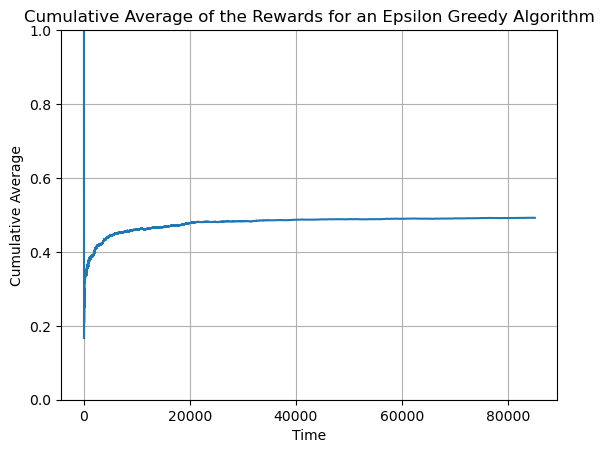

In [134]:
payoffs_3 = block_policy_evaluator_epsilon_faster(df, epsilon_value = 0.15)
cumulative_average = np.cumsum(payoffs_3) / np.arange(1, len(payoffs_3)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

The code is around 2.5 times faster without concatenating.